In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# Given parameters
L = 3.34e5  # Latent heat of phase change (KJ/m^3)
C_i = 1.672  # Heat capacity of ice (KJ/(m^3·K))
C_l = 4.18  # Heat capacity of water (KJ/(m^3·K))
lambda_i = 2.210  # Thermal conductivity of ice (W/(m·K))
lambda_l = 0.465  # Thermal conductivity of water (W/(m·K))

# Unknown parameters
lambda_f = 1.5  # Thermal conductivity of soil matrix (W/(m·K))
C_f = 1.5  # Heat capacity of soil matrix (KJ/(m^3·K))
eta = 0.4  # Porosity of the soil
b = 1.5  # Coefficient for unfrozen water content
T_nabla = -1.0  # Freezing temperature of the soil (°C)

# Discretization parameters
Nx = 50  # Number of spatial points
Nt = 100000  # Number of time steps
Lx = 5.0  # Length of the domain (m) (from 0 m to 5.0 m)
T_total = 365.0  # Total time (days)
dx = Lx / (Nx - 1)  # Spatial step size
dt = T_total / Nt  # Time step size

# Define functions
def pore_water_content(T, T_nabla, b):
    """Calculate pore water content."""
    return np.where(T >= T_nabla, 1, np.abs(T_nabla)**b * np.abs(T)**(-b))

def unfrozen_water_content(T, T_nabla, b, eta):
    """Calculate unfrozen water content."""
    phi = pore_water_content(T, T_nabla, b)
    return eta * phi

def effective_concentration(C_f, C_l, C_i, eta, phi):
    """Calculate effective heat capacity."""
    C_t_value = C_f + eta * (C_l - C_i)
    return phi * C_t_value + (1 - phi) * C_f

def effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi):
    """Calculate effective thermal conductivity."""
    lambda_t_value = lambda_f * (lambda_l / lambda_i) ** eta
    return lambda_t_value ** phi * lambda_f ** (1 - phi)

# Boundary condition function
def temperature(t):
    """Boundary temperature function at x=0."""
    return 4.03 + 16.11 * np.sin((2 * np.pi * t / 365) - 1.709)  # Temperature in °C

# Linear interpolation function
def linear_interpolation(z, z1, z2, T1, T2):
    """
    Linear interpolation to calculate temperature at depth z.
    """
    if z1 == z2:
        raise ValueError("z1 and z2 cannot be the same.")
    return T1 + (T2 - T1) / (z2 - z1) * (z - z1)

# Initialize temperature profile using linear interpolation
def initialize_temperature_profile(depths, z1, z2, T1, T2):
    """
    Initialize temperature profile using linear interpolation.
    """
    temperatures = np.zeros_like(depths)
    for i, z in enumerate(depths):
        temperatures[i] = linear_interpolation(z, z1, z2, T1, T2)
    return temperatures

# Define spatial grid
x = np.linspace(0, Lx, Nx)  # Spatial grid from 0 m to 5.0 m

# Define boundary conditions for interpolation
z1, T1 = 0.0, temperature(0)  # Upper boundary condition at x=0 m
z2, T2 = Lx, 1.0  # Lower boundary condition at x=5.0 m (1 °C)

# Initialize temperature profile
T = initialize_temperature_profile(x, z1, z2, T1, T2)

# Initialize the temperature field as a 2D array
T_field = np.zeros((Nx, Nt))  # Temperature field: T(x, t)
T_field[:, 0] = T  # Set initial condition

# Time-stepping loop
for n in range(Nt):
    t_n = n * dt
    
    # Apply Dirichlet boundary conditions
    T[0] = temperature(t_n)  # Upper boundary condition at x=0 m
    T[-1] = 1.0  # Lower boundary condition at x=5.0 m (1 °C)
    
    # Compute effective properties
    phi = pore_water_content(T, T_nabla, b)
    theta = unfrozen_water_content(T, T_nabla, b, eta)
    C_eff = effective_concentration(C_f, C_l, C_i, eta, phi)
    lambda_eff = effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi)
    
    # Debugging: Print intermediate values
    if np.any(np.isnan(C_eff)) or np.any(np.isnan(lambda_eff)):
        print(f"Warning: NaN detected at t = {t_n}")
        print("C_eff:", C_eff)
        print("lambda_eff:", lambda_eff)
        break
    
    # Compute the right-hand side of the discretized equation
    rhs = np.zeros(Nx)
    for i in range(1, Nx-1):
        lambda_plus = 0.5 * (lambda_eff[i] + lambda_eff[i+1])
        lambda_minus = 0.5 * (lambda_eff[i] + lambda_eff[i-1])
        rhs[i] = (lambda_plus * (T[i+1] - T[i]) - lambda_minus * (T[i] - T[i-1])) / dx**2
    
    # Update temperature
    T[1:-1] += dt * (rhs[1:-1] - L * (theta[1:-1] - theta[1:-1]) / dt) / C_eff[1:-1]
    
    # Store the temperature field at the current time step
    T_field[:, n] = T


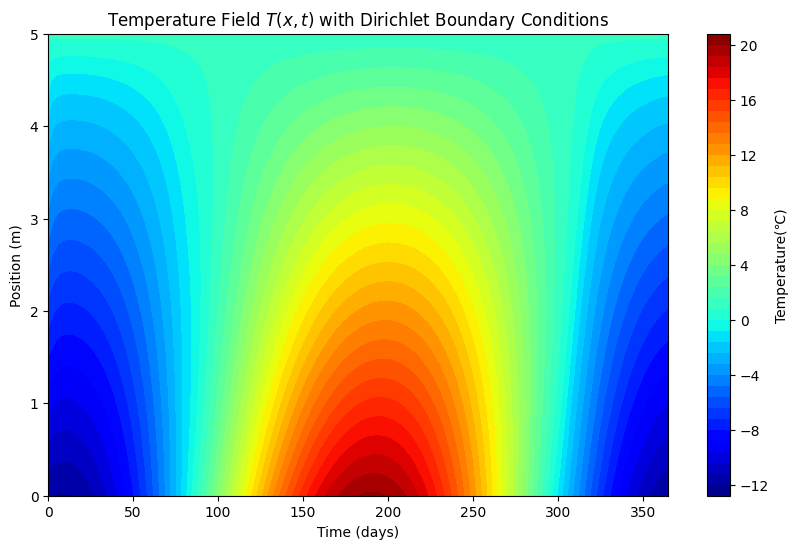

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the temperature field as a 2D image
plt.figure(figsize=(10, 6))
# analytical solutions
plt.contourf(np.linspace(0, T_total, Nt), x, T_field, levels=50, cmap='jet')
plt.colorbar(label='Temperature(℃)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('FDM Solution')
plt.xlabel('Time (days)')
plt.ylabel('Position (m)')
plt.title('Temperature Field $T(x, t)$')
plt.show()

# Save the plot as an image
plt.savefig('temperature_field_dirichlet.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Temperature(℃)')

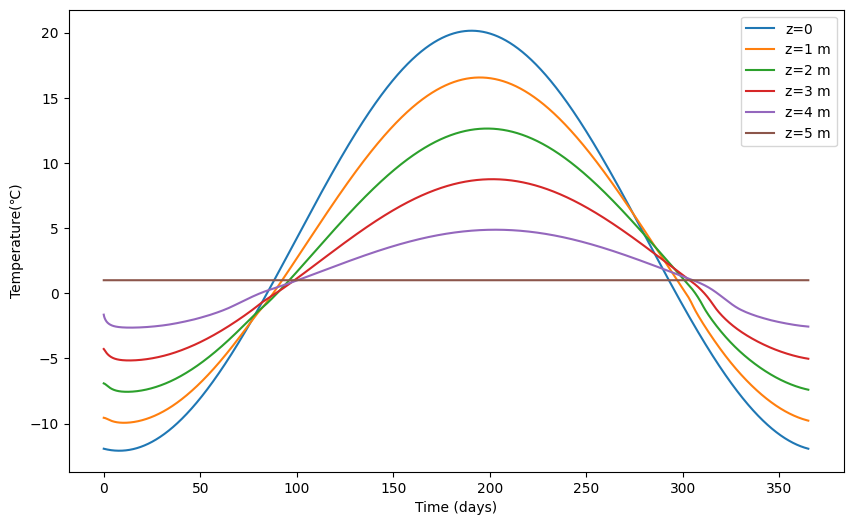

In [10]:
plt.figure(figsize=(10, 6))
T_field_FDM = T_field.shape;
plt.plot(np.linspace(0, T_total, Nt),T_field[0,:],label = 'z=0')
plt.plot(np.linspace(0, T_total, Nt),T_field[9,:],label = 'z=1 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[19,:],label = 'z=2 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[29,:],label = 'z=3 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[39,:],label = 'z=4 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[49,:],label = 'z=5 m')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Temperature(℃)')